In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## 1.0. Installing needed libraries

In [ ]:
# please read https://github.com/librosa/librosa
!pip install librosa --user

In [2]:
# you may need ffmpeg to be installed
# !conda install -c conda-forge ffmpeg
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6083 sha256=0d3a19f36cf7964eca85a5b64d57c3d48ab7e4ef03990173c79838d0a2767351
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


## 1.1. Reading and resampling audio tracks database

Based on [this librosa demo](https://github.com/librosa/librosa/blob/main/examples/LibROSA%20demo.ipynb). we read audio files in `mp3` format and then resample to common sample rate of 22kHz. 

Make sure you've downloaded all 4 files from [here](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/mp3).

In [1]:
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

drivePath = "/content/drive/MyDrive/AIR/"

audios = ['mp3/ACDC.mp3', 'mp3/iamthemorning.mp3', 'mp3/Little Big.mp3']
request_audio = 'mp3/request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050
# reading all audios
for path in audios:
    dataset[path] = read_and_resample(drivePath + path, sample_rate)

# reading request audio
request_data = read_and_resample(drivePath + request_audio, sample_rate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/ACDC.mp3 length is 4.88 min


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/iamthemorning.mp3 length is 3.83 min


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/Little Big.mp3 length is 2.68 min


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/request.mp3 length is 0.17 min


## 1.2. Visualizing example spectrogram

We use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception of pitch rather than normal frequencies. No theoretical basis, just for you to know what is this :)

Spectrogram shape: (128, 12599)


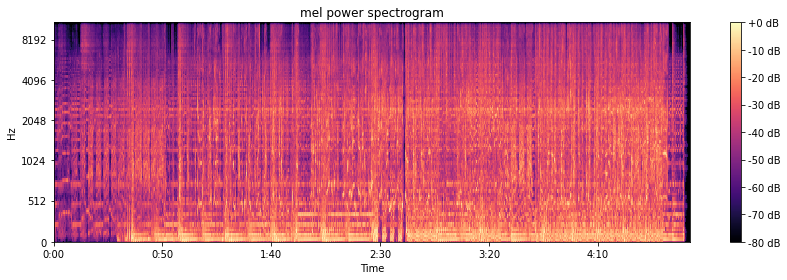

In [2]:
import numpy as np
import matplotlib.pyplot as plt

y = dataset['mp3/ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## 1.3. Forming constellations

We will do something like this from our spectrogram. Not exactly as in the paper, but very similar :)

<img src="http://coding-geek.com/wp-content/uploads/2015/05/shazam_filtered_spectrogram-min.png" width="400"/>

This will include:
- get spectrogram
- find local maxima with [computer vision algrithm (wow!)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html): run maximum filtering and then compare original values with filtered.
- `ndimage.label()` labels different connected components
- `ndimage.find_objects()` returns their coordinates
- for each connected component of size 1 (`(dx.stop - dx.start) * (dy.stop - dy.start) == 1`) save a center, which will correspond to a "star"

Time resolution: 0.02321972427354941
mp3/ACDC.mp3


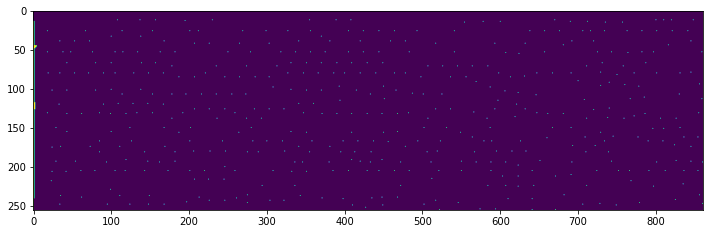

6587
mp3/iamthemorning.mp3


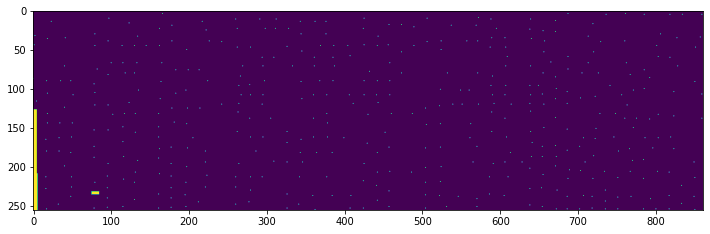

5128
mp3/Little Big.mp3


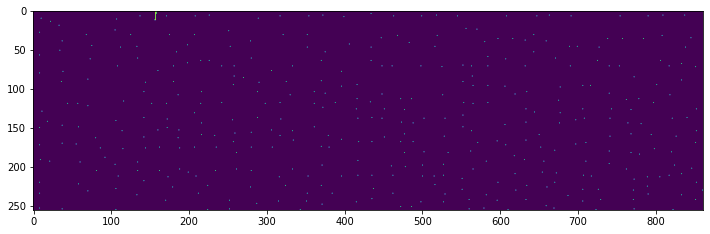

3479
mp3/request.mp3


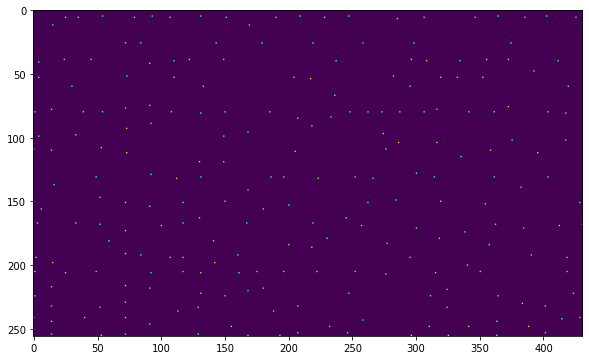

234


In [4]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["mp3/ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print("Time resolution:", time_resolution)

def form_constellation(name, wav, sample_rate, time_resolution):
    S = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=256, fmax=4000)
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / time_resolution)
    hi = int(20 / time_resolution)
    print(name)
    # here we show results of max filter. This is NOT exactly the same which is saved.
    # Only single-point CC will fall into `points` array
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi])
    plt.show()
    print(len(points))
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate, time_resolution)

request_constellation = form_constellation(request_audio, request_data, sample_rate, time_resolution)

## 1.4. [50] Build index from constellations 

### 1.4.1. [30] Index construction

Here you will build an in-memory index from constellations. Follow the algorithm:
1. For every "star" $(t_1, f_1)$ on constellation consider some constellation window (`target`) of time and frequency shift. In example this is `(+1, +5) sec` and `(-50, +50) Hz`. In original paper they propose to use SOME "stars". If you propose your own selection method - this is also good, as it speeds up computations.
2. If a "star" $(t_2, f_2)$ falls into a `target` window, create or update and index entry. Form a key as $(f1, f2, \Delta t=t_2-t_1)$, and a value is $(t_1, filename)$.

In [26]:
print(time_resolution)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 

index = {}
request = {}

def build_constellation_index(constellation_collection, target):
    # TODO: build shazam index for a collection of constellations
    # consider some window (target) for every point
    # for every point inside this window make an entry in the index (or update it, if the key exists)
    # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)

    indexEntry = dict()

    targetFU = target[3] # Upper frequency limit
    targetFL = target[2] # Lower frequency limit

    targetTU = target[1] # Upper time limit
    targetTL = target[0] # Lower time limit

    # i = 0

    for filename in constellation_collection:
      print(filename)
      point = constellation_collection[filename]
      lpoint = len(point)

      for index, star1 in enumerate(point):
        for neighbor in range(lpoint):
          maxNeighbor = index + neighbor
          if maxNeighbor < lpoint:
            
            timePoint1 = star1[0]
            freqPoint1 = star1[1]

            timePoint2 = point[maxNeighbor][0]
            freqPoint2 = point[maxNeighbor][1]

            freqdifference = freqPoint2 - freqPoint1

            dt = timePoint2 - timePoint1

            if targetFL <= freqdifference and freqdifference <= targetFU:
              if targetTL <= dt and dt <= targetTU:
                key = (freqPoint1, freqPoint2, dt)
                if key in indexEntry:
                  if (timePoint1, filename) not in indexEntry[key]:
                    indexEntry[key].append((timePoint1, filename))                    
                else:
                  indexEntry[key] = [(timePoint1, filename)]
            
            
              # # dt = abs(timePoint1 - timePoint2)
              # dt = timePoint1 - timePoint2
              # # if targetTL <= dt and dt <= targetTU:  
              # key = (freqPoint1, freqPoint2, dt)
              # if key in indexEntry:
              #   if (timePoint1, filename) not in indexEntry[key]:
              #     indexEntry[key].append((timePoint1, filename))                    
              # else:
              #   indexEntry[key] = [(timePoint1, filename)]
            

    result_index = indexEntry    
    return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

0.02321972427354941
mp3/ACDC.mp3
mp3/iamthemorning.mp3
mp3/Little Big.mp3
mp3/request.mp3


### 1.4.2. [20] Compare `request.mp3` track with the database using index queries.

1. For every audio file from index find all keys that match query keys.
2. for every such match calculate time offset (difference between audio $t_1$ and query $t_1$)
3. Display counts of matches for every time offset (using histogram, for example)

mp3/ACDC.mp3


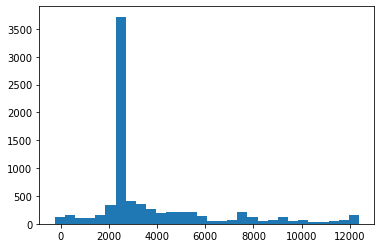

mp3/Little Big.mp3


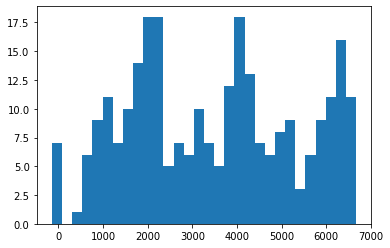

mp3/iamthemorning.mp3


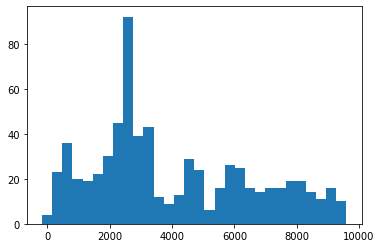

In [36]:
# kes = (26, 33, 82)
# val = [(18, 'mp3/ACDC.mp3'), (1130, 'mp3/ACDC.mp3')]
from collections import Counter


def getMatchesOffSetTime(request, index):  
  matchesOffSetTime = dict()

  for reqIndex in request:
    key = reqIndex
    if key in index:
      queryval = request[key]
      audioValue = index[key] 

      for av in audioValue: 
        audioTime = av[0]
        audioID = av[1]

        if audioID not in matchesOffSetTime: 
          matchesOffSetTime[audioID] = []

        for qv in queryval: 
          querytime = qv[0]  
          queryID = qv[1]    
          # offset = abs(audioTime - querytime)
          offset = audioTime - querytime

          matchesOffSetTime[audioID].append(offset)
  
  return matchesOffSetTime

from collections import Counter

matchesOffSetTime = getMatchesOffSetTime(request, index)

for key in matchesOffSetTime:
  values = []
  keys = []
  print(key)
  # k = Counter(matchesOffSetTime[key])
  # # # print(Counter(time_offsets[f]))
  # for idx in k:
  #   values.append(k[idx])
  #   keys.append(idx)
  plt.hist(matchesOffSetTime[key], bins = 30)
  # plt.bar(keys, values, width=3.5)
  plt.show()

### 1.4.3. [Extra] Similarity function

Implement a function, which will be estimating similarity of 2 audio tracks in some numbers. It should return 2 numbers: relevance estimation and audio offset (how start of one track is shifted with respect to another, if possible).

We are not giving any particular instructions on HOW to do this, but you can definitely start thinking from:
1. Norming and thresholding.
2. [Mode](https://en.wikipedia.org/wiki/Mode_(statistics)). E.g. [in python](https://docs.python.org/3/library/statistics.html).
3. [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis). E.g. [in python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html).

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/ACDC.mp3 length is 4.88 min


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/content/drive/MyDrive/AIR/mp3/request.mp3 length is 0.17 min
mp3/ACDC.mp3


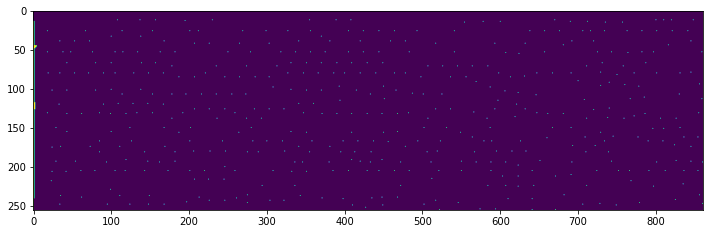

6587
mp3/request.mp3


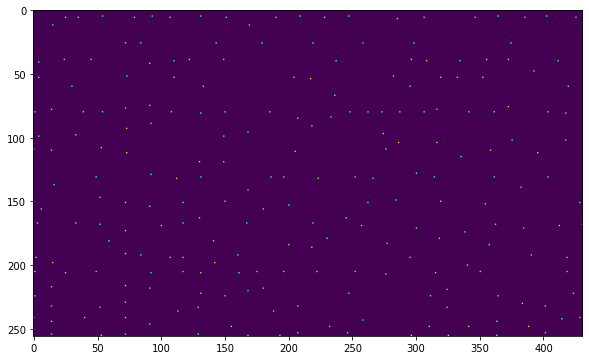

234
mp3/ACDC.mp3
mp3/request.mp3


In [37]:
from scipy.stats import kurtosis

def similarity(audio1, audio2):
    
    # ... write your code here

    target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 
    sample_rate = 22050


    audio1_read = read_and_resample(drivePath + audio1, sample_rate)
    audio2_read = read_and_resample(drivePath + audio2, sample_rate)
    # print(audio1)
    # print(audio2)

    audio1_constellation = form_constellation(audio1, audio1_read, sample_rate, time_resolution)
    audio2_constellation = form_constellation(audio2, audio2_read, sample_rate, time_resolution)

    audio1_index = build_constellation_index({audio1:audio1_constellation}, target)
    audio2_index = build_constellation_index({audio2:audio2_constellation}, target)

    matchesOffSetTime = getMatchesOffSetTime(audio1_index, audio2_index)

    mode = 0
    kurt = 0
    normValue = 65
    
    for key in matchesOffSetTime:
        val = matchesOffSetTime[key]
        k = Counter(val)
        mode = k.most_common()
        val1 = []
        for k in mode:
          val1.append(k[0])
        kurt = kurtosis(val1) * normValue
        sim = kurtosis(val)
      

    similarity = sim
    offset = kurt
    return similarity, offset


sim, off = similarity('mp3/ACDC.mp3', 'mp3/request.mp3')
assert abs(abs(off) - 60) < 5, "Offset value for these 2 tracks should be around 1 minute."

# 2. [50] Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## 2.1. Get dataset

We will use `Caltech 101` dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## 2.2. SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images (use in your code `cv.drawMatches()` function to display keypoint matches).

In [17]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
!pip install annoy

128


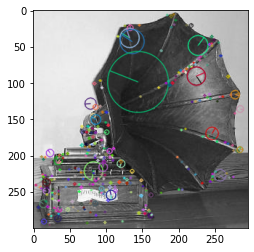

In [40]:
import cv2 as cv
from matplotlib import pyplot as plt

drivePath = "/content/drive/MyDrive/AIR/"

img_dir = drivePath+ '101_ObjectCategories'

img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
kp1, des1 = sift.compute(gray, kp)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## 2.3. [50] Index of keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, you will index descriptors of all images using some data structure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a new (query) image you will generate its descriptors, and for each of them find its `k` nearest neighbors (using Euclidean or Cosine distance, which you prefer). Finally, you will sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors (more matches -- higher the rank).

### 2.3.1. [30] Build an index

Read all images, saving category information. For every image generate SIFT descriptors and index them using HNSW from [`nmslib`](https://github.com/nmslib/nmslib), FAISS, Annoy or whatever.

In [50]:
## TODO do your job here
## key is a descriptor, value is a filename

import os
from os import listdir
from os.path import isfile, join

def computeSIFT(img):
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  kp = sift.detect(gray,None)
  kp1, des = sift.compute(gray, kp)

  return des

def category_data(path, category):
  X = []
  y = []
  files = [f for f in listdir(path) if isfile(join(path, f))]  
  for filee in files:
    newPath = path+ "/" + filee
    label = category + "/" + filee

    img = cv.imread(newPath)
    if img is not None:
      des = computeSIFT(img)
      X.append(des)
      y.append(label)
  return X, y

def read_dataset(datasetPath):
  datasetX = []
  datasety = []
  i = 0
  for category in os.listdir(datasetPath):
    newPath = datasetPath+ category
    if os.path.isdir(newPath):
      X , y = category_data(newPath, category)
      i += 1
      datasetX.extend(X)
      datasety.extend(y)
  return datasetX, datasety


datasetPath = img_dir + "/"

# print(os.listdir(datasetPath))

X, y = read_dataset(datasetPath)


# import pickle
# with open('features.pkl', 'wb') as f:
#   pickle.dump(X, f)

# with open('labels.pkl', 'wb') as f:
#   pickle.dump(y, f)


# with open('features.pkl', 'rb') as f:
#   X = pickle.load(f)

# with open('labels.pkl', 'rb') as f:
#   y = pickle.load(f)

from annoy import AnnoyIndex
index = AnnoyIndex(128, 'euclidean')  
for idx, feature in enumerate(X):
  if feature is not None: 
    for vec in feature:
      index.add_item(idx, vec)
index.build(10)
# index.save('index.ann')s

True


In [ ]:
# index = AnnoyIndex(128, 'angular')
# index.load('index.ann') # super fast, will just mmap the file
# import nmslib

# # initialize a new index, using a HNSW index on sift
# index = nmslib.init(method='hnsw', space='l2sqr_sift', 
#              data_type=nmslib.DataType.DENSE_UINT8_VECTOR, 
#              dtype=nmslib.DistType.INT)

# def computeSIFT(img):
#   gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#   sift = cv.xfeatures2d.SIFT_create()
#   kp = sift.detect(gray, None)

#   kp1, des1 = sift.compute(gray, kp)
#   des1 = des1.flatten()-

#   return des1

### 2.3.2. [20] Implement search function

Implement a function which returns `k` neighbours (names) sorted for a given image name.

In [49]:
from collections import Counter

def anns(imagename, k=10):
    ## ... do your job here

    drivePath = "/content/drive/MyDrive/AIR/"

    img_dir = '101_ObjectCategories'

    newPath = drivePath + img_dir + "/" + imagename

    img = cv.imread(newPath)
    if img is not None:
      des = computeSIFT(img)

    pred = []
    for vec in des:
      if vec is not None and len(vec) == 128:          
        for image_class in index.get_nns_by_vector(vec, 1):
            pred.append(y[image_class])
    counter=Counter(pred)
    idx = counter.most_common()

    liss = []

    for id, k in enumerate(idx):
      sim = k[1]
      res = k[0]
      liss.append((sim, res))

    return sorted(liss[173:183])

anns(filename, 10)
# finds query image in the result, as it is indexed
filename = 'strawberry/image_0022.jpg'
assert any([f[1] == filename for f in anns(filename, 10)]), "Should return a duplicate"

## 2.3.3. [Extra] Estimate quality

Build a bucket from these images.
```
accordion/image_0043.jpg
laptop/image_0052.jpg
pagoda/image_0038.jpg
revolver/image_0043.jpg
rhino/image_0040.jpg
sea_horse/image_0038.jpg
soccer_ball/image_0057.jpg
starfish/image_0011.jpg
strawberry/image_0022.jpg
wrench/image_0013.jpg
```
Consider `relevant` if **class of the query and class of the result match**. Compute `DCG` and `pFound` for every query and for the bucket in average.

In [34]:
# import math

# ## write your code here
# queries = ["accordion/image_0043.jpg", "laptop/image_0052.jpg", 
#            "pagoda/image_0038.jpg", "revolver/image_0043.jpg",
#            "rhino/image_0040.jpg", "sea_horse/image_0038.jpg", 
#            "soccer_ball/image_0057.jpg", "starfish/image_0011.jpg", 
#            "strawberry/image_0022.jpg", "wrench/image_0013.jpg"]

# results = []
# pLook = []
# pRel = []
# ind = 0
# pBreak = 0.15

# for idx, query in enumerate(queries):
#   tp = 0
#   fp = 1
#   jl = id
#   match = anns(query)
#   pLook.append(0)
#   pRel.append(0)
#   pLook[ind] = 0
#   pRel[ind] = 0
#   for id, res in enumerate(match):
#     if res[1] == query:
#       tp = 1/math.log2(id+1)
#       if ind == 0:
#         pLook[ind] = 1
#         pRel[ind] = 0.4
#       else:
#         pl = pLook[ind-1]
#         val = pl * (1-0.4) * pBreak
#         pLook[ind] = val
#         pRel[ind] = 0.4
#       break
#     else:
#       fp += 1
#   ind +=1
#   matQuery = tp / fp
#   results.append(tp)

# dcg = sum(results)
# print("Bucket DCG: ",dcg/(len(results)))
# pFound = 0
# for idx, val in enumerate(pLook):
#   pFound += val * pRel[idx]
# print("Bucket pFound: ",pFound/(len(results)))